In [1]:
import os
import numpy as np

In [6]:
from pyiron_workflow import Workflow, function_node

In [12]:
def generate_input(x, y, path, input_file="input.gnu"):
    data_file = os.path.join(path, 'xy.dat')
    np.savetxt(data_file, np.stack((x, y), axis=-1))
    gnuplot_script = "f(x) = a*x+b\nfit f(x) \"xy.dat\" using 1:2 via a,b"
    gnuplot_file = os.path.join(path, input_file)
    with open(gnuplot_file, "w") as f:
        f.write(gnuplot_script)
    return gnuplot_script

In [3]:
executable = "gnuplot \"input.gnu\""

In [4]:
def _get_gnuplot_parameter_line(content):
    for ii, line in enumerate(content):
        if line.startswith("Final set of parameters"):
            return ii + 2
    raise ValueError("line not found")
    
def get_gnuplot_parameters(content):
    parameter_line = _get_gnuplot_parameter_line(content)
    slope = float(content[parameter_line].split("=")[1].split()[0])
    intercept = float(content[parameter_line + 1].split("=")[1].split()[0])
    return slope, intercept

def parse_output(path):
    data_file = os.path.join(path, 'fit.log')
    with open(data_file, "r") as f:
        content = f.readlines()
    return get_gnuplot_parameters(content)

In [8]:
import subprocess

In [27]:
@Workflow.wrap.as_function_node
def create_working_directory(directory_name):
    if not os.exists(directory_name):
        os.mkdir(directory_name, exist_ok=True)
    return directory_name

@Workflow.wrap.as_function_node
def run_executable(input_file):
    output = subprocess.check_output(f"gnuplot \"{input_file}\"", shell=True).decode()
    return output

In [28]:
wf = Workflow("gnuplot")

In [29]:
x = np.linspace(0, 2 * np.pi)
y = np.sin(x)

In [30]:
wf.directory = create_working_directory("gnuplot")
wf.gen_input = function_node(generate_input, x=x, y=y, path=wf.directory)
wf.

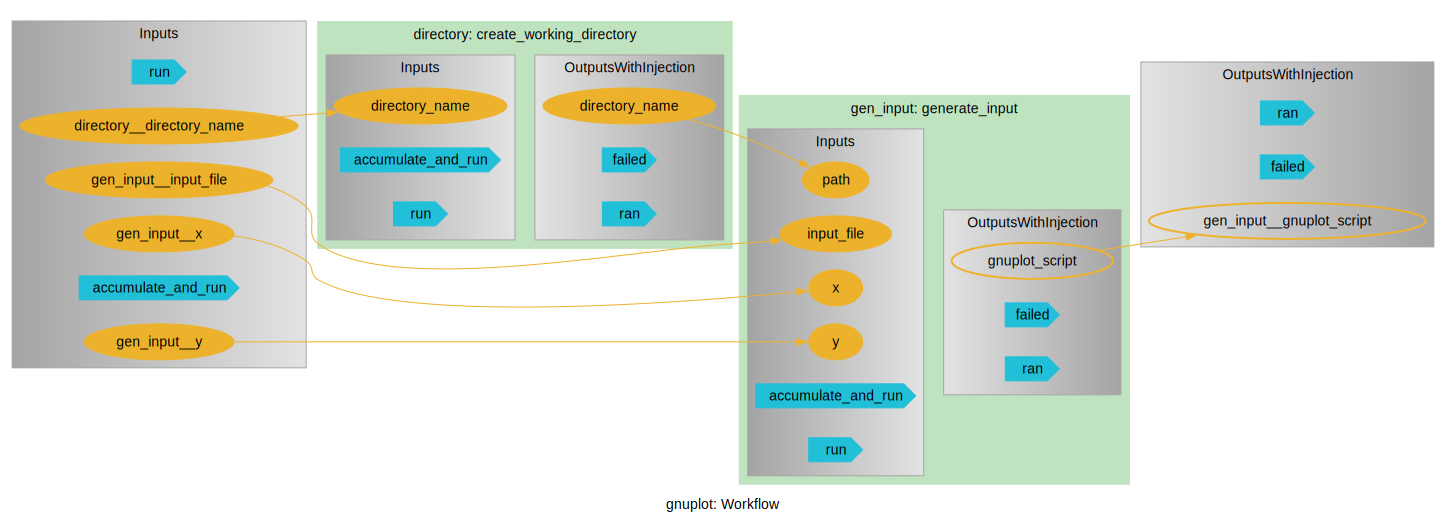

In [32]:
wf.draw()